<a href="https://colab.research.google.com/github/mohitshah3111999/Facial-Expression-Recognition/blob/main/BTP_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-qckl4ln1
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-qckl4ln1
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=28cbc8c723f4541b5d65e13af3de9cab80d21670847f4c39fc3268d2e7e78927
  Stored in directory: /tmp/pip-ephem-wheel-cache-ix_rvxoj/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface
     |████████████████████████████████| 50 kB 2.9 MB/s 


20951

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from sklearn.metrics import *
from keras.models import Model

import tensorflow_hub as hub

from sklearn.metrics import confusion_matrix

import os
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/facial_expression/

Mounted at /content/drive
/content/drive/MyDrive/facial_expression


In [ ]:
def get_datagen(directory, arg=False):
    if arg:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            directory,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = False,
            class_mode='categorical',
            batch_size=128)

In [ ]:
train_generator  = get_datagen('.//FER2013/train', True)
val_generator = get_datagen('.//FER2013/validation')
test_generator  = get_datagen('.//FER2013/test')

Found 27742 images belonging to 7 classes.
Found 3544 images belonging to 7 classes.
Found 3542 images belonging to 7 classes.


In [ ]:
model_no_top = VGGFace(model='resnet50', include_top=False, input_shape=(197, 197, 3), pooling='avg')
last_layer = model_no_top.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax', name='classifier')(x)

batch_normalization_index = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(170):
    if i not in batch_normalization_index:
        model_no_top.layers[i].trainable = False

model = Model(model_no_top.input, output)

sgd = SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

94707712/94694792 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 197, 197, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 99, 99, 64)   9408        ['input_1[0][0]']                
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 99, 99, 64)  256         ['conv1/7x7_s2[0][0]']           
 ation)                                                                                           
                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
try:
  os.mkdir("checkpoint")
except:
  pass

In [ ]:
reduceLr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
file_name = 'best_model_resnet.h5'
checkpoint_path= os.path.join('checkpoint',file_name)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 mode='max')

stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

callback_list = [checkpoint, reduceLr, stopping]

In [ ]:
history = model.fit(train_generator, batch_size=128, epochs=50, validation_data=val_generator, callbacks=callback_list) 

Epoch 1/50
217/217 [==============================] - ETA: 0s - loss: 1.9052 - accuracy: 0.3308 
Epoch 00001: val_accuracy improved from -inf to 0.17156, saving model to checkpoint/best_model_resnet.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


217/217 [==============================] - 8047s 37s/step - loss: 1.9052 - accuracy: 0.3308 - val_loss: 1.8956 - val_accuracy: 0.1716 - lr: 0.0100
Epoch 2/50
217/217 [==============================] - ETA: 0s - loss: 1.3795 - accuracy: 0.4727
Epoch 00002: val_accuracy improved from 0.17156 to 0.18200, saving model to checkpoint/best_model_resnet.h5
217/217 [==============================] - 237s 1s/step - loss: 1.3795 - accuracy: 0.4727 - val_loss: 1.8873 - val_accuracy: 0.1820 - lr: 0.0100
Epoch 3/50
217/217 [==============================] - ETA: 0s - loss: 1.2752 - accuracy: 0.5185
Epoch 00003: val_accuracy improved from 0.18200 to 0.40801, saving model to checkpoint/best_model_resnet.h5
217/217 [==============================] - 234s 1s/step - loss: 1.2752 - accuracy: 0.5185 - val_loss: 1.5250 - val_accuracy: 0.4080 - lr: 0.0100
Epoch 4/50
217/217 [==============================] - ETA: 0s - loss: 1.2128 - accuracy: 0.5438
Epoch 00004: val_accuracy improved from 0.40801 to 0.58973,

In [ ]:
%cd checkpoint/
os.listdir()

/content/drive/My Drive/facial_expression/checkpoint


['best_model_mobilenet.h5', 'best_model_custom.h5', 'best_model_resnet.h5']

In [ ]:
model = load_model("best_model_resnet.h5", custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()
%cd ..

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 197, 197, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 99, 99, 64)   9408        ['input_1[0][0]']                
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 99, 99, 64)  256         ['conv1/7x7_s2[0][0]']           
 ation)                                                                                           
                                                                                              

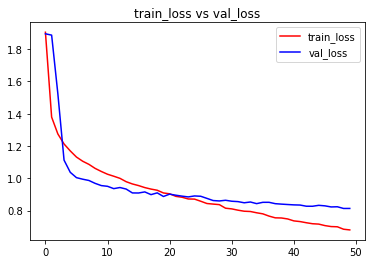

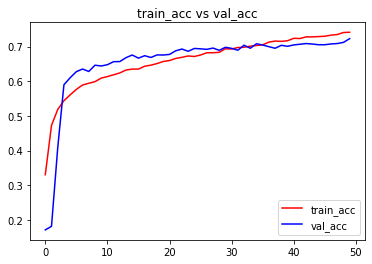

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pickle

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs, train_loss, 'r', label='train_loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs, train_acc, 'r', label='train_acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(test_generator)
Y_pred_classes = np.argmax(Y_pred,axis = 1)

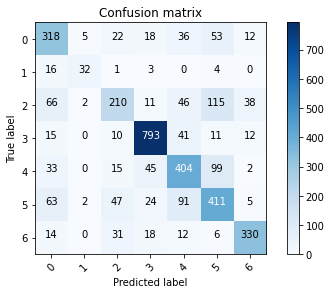

In [ ]:
Y_true = test_generator.classes
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = range(7))

In [ ]:
score, acc = model.evaluate(test_generator, batch_size=128)
print("Test loss: {}".format(score))
print("Test accuracy: {}".format(acc))

28/28 [==============================] - 9s 270ms/step - loss: 0.8490 - accuracy: 0.7053
Test loss: 0.8489865660667419
Test accuracy: 0.7052512764930725
